<a href="https://colab.research.google.com/github/obaidsafi51/InternIntelligence_Predictive_Model/blob/main/Tast_1_Intern_Intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install xgboost seaborn


Data shape: (20640, 9)
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseValue  
0    -122.23          4.526  
1    -122.22          3.585  
2    -122.24          3.521  
3    -122.25          3.413  
4    -122.25          3.422  


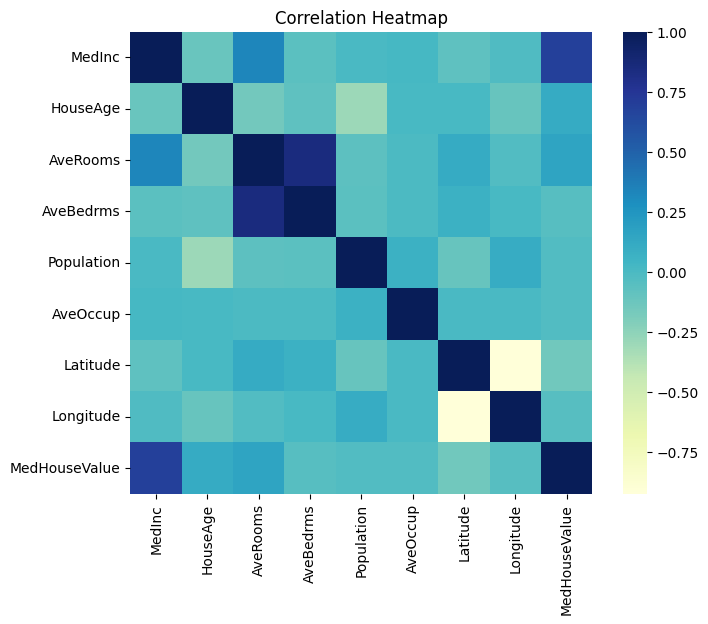


Correlation with MedHouseValue:
 MedHouseValue    1.000000
MedInc           0.688075
AveRooms         0.151948
HouseAge         0.105623
AveOccup        -0.023737
Population      -0.024650
Longitude       -0.045967
AveBedrms       -0.046701
Latitude        -0.144160
Name: MedHouseValue, dtype: float64

Train set size: (16512, 8)
Test set size:  (4128, 8)

Original training shape: (16512, 8)
New training shape with polynomial features: (16512, 11)
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Final Model Performance with Polynomial Features + XGBoost:
  MAE: 0.31
  MSE: 0.22
  R²:  0.8319


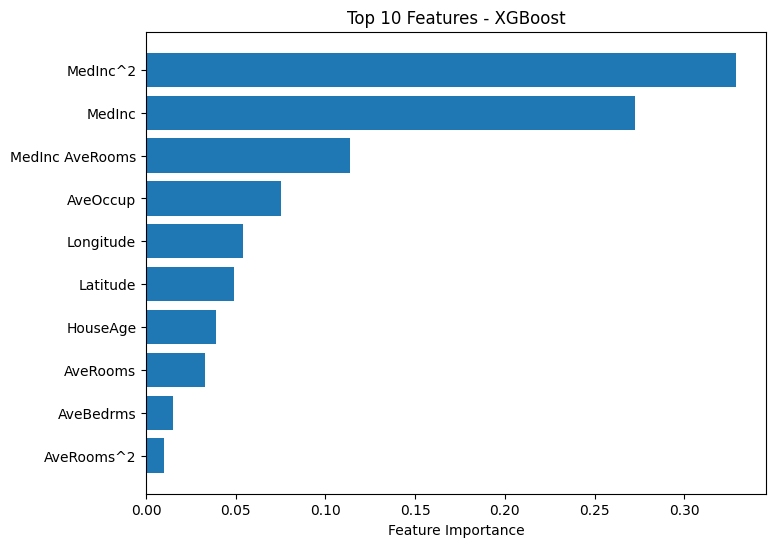

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df["MedHouseValue"] = housing.target  # target column

print("Data shape:", df.shape)
print(df.head())

corr_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, cmap="YlGnBu", square=True)
plt.title("Correlation Heatmap")
plt.show()

# Print correlation with the target
target_corr = corr_matrix["MedHouseValue"].sort_values(ascending=False)
print("\nCorrelation with MedHouseValue:\n", target_corr)

X = df.drop("MedHouseValue", axis=1)
y = df["MedHouseValue"]

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTrain set size:", X_train.shape)
print("Test set size: ", X_test.shape)

# We'll create polynomial features for 'MedInc' and 'AveRooms' as a demo
poly_cols = ["MedInc", "AveRooms"]
other_cols = [col for col in X_train.columns if col not in poly_cols]

poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit only on training data to avoid data leakage
poly_train = poly.fit_transform(X_train[poly_cols])
poly_test  = poly.transform(X_test[poly_cols])

# Convert to DataFrame
poly_features = poly.get_feature_names_out(poly_cols)
df_poly_train = pd.DataFrame(poly_train, columns=poly_features, index=X_train.index)
df_poly_test  = pd.DataFrame(poly_test,  columns=poly_features, index=X_test.index)

# Concatenate polynomial columns with the remaining original columns
X_train_poly = pd.concat([X_train[other_cols], df_poly_train], axis=1)
X_test_poly  = pd.concat([X_test[other_cols], df_poly_test], axis=1)

print("\nOriginal training shape:", X_train.shape)
print("New training shape with polynomial features:", X_train_poly.shape)


# ADVANCED MODEL: XGBOOST + HYPERPARAMETER TUNING

xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

param_dist = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=5,  # keep small for demo; increase for more thorough search
    scoring="neg_mean_squared_error",  # or "neg_mean_absolute_error"
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the search on the polynomial-augmented training data
random_search.fit(X_train_poly, y_train)

best_model = random_search.best_estimator_
print("\nBest Hyperparameters:", random_search.best_params_)

#Training and Evaluation
best_model.fit(X_train_poly, y_train)
y_pred = best_model.predict(X_test_poly)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("\nFinal Model Performance with Polynomial Features + XGBoost:")
print(f"  MAE: {mae:.2f}")
print(f"  MSE: {mse:.2f}")
print(f"  R²:  {r2:.4f}")

#Feature Importance
importances = best_model.feature_importances_
feature_names = X_train_poly.columns

# Sort by importance (descending)
indices = np.argsort(importances)[::-1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

plt.figure(figsize=(8, 6))
plt.barh(sorted_features[:10], sorted_importances[:10])
plt.gca().invert_yaxis()  # highest importance at top
plt.xlabel("Feature Importance")
plt.title("Top 10 Features - XGBoost")
plt.show()
